In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
from networkx.readwrite import json_graph
import community.community_louvain as community_louvain

In [51]:
# load merged dataset (from kristian code)
df = pd.read_csv("Merged_Reviews_and_Metadata.csv")

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/1838269180.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_Reviews_and_Metadata.csv")


In [ ]:
# remove when combining
df.head(4)

,rating,review_title,text,asin,parent_asin,user_id,timestamp,helpful_vote,main_category,movie_title,average_rating,rating_number,description,price,categories
0,5.0,AWESOME DVD-GREAT FOR BEGINNERS & BUSY PEOPLE,This DVD was GREAT! I am a stay at home mom w...,B0002J58ME,B0002J58ME,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2006-05-04 03:31:32.000,4,Movies & TV,10 Minute Solution: Pilates,4.6,793.0,['Originally released in 2004. Directed by And...,8.77,"['Movies & TV', 'Featured Categories', 'DVD', ..."
1,5.0,COLUMBO movie collection,I grew up with this one. couldn't wait week to...,B001JNNDRY,B001JNNDRY,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,2013-03-24 01:28:38.000,1,Movies & TV,Columbo: Mystery Movie Collection 1990 [DVD],4.7,383.0,['The legendary Peter Falk returns in his four...,13.4,"['Movies & TV', 'Boxed Sets', 'Mystery & Suspe..."
2,4.0,Great movie IMO,"This is a fun, colorful, entertaining movie. C...",B001JV5BF8,B001JV5BF8,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,2014-05-13 14:41:33.000,1,Movies & TV,The Wiz,4.8,7896.0,"[""Ease on down the yellow-brick road with The ...",10.43,"['Movies & TV', 'Music Artists', 'Jackson, Mic..."
3,5.0,Wow - the high definition Bluray is impressive.,I loved this show as a kid. Glad to have it t...,B07QKVVKQH,B07QKVVKQH,AHCPZDDPHJE3G7M6ST5WGRPLXHOA,2022-03-02 12:24:51.258,1,Movies & TV,Space: 1999 - The Complete Series,4.6,523.0,[],52.24,"['Movies & TV', 'Featured Categories', 'Blu-ra..."


In [58]:
# add sentiment score
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce') 

sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])


In [ ]:
# remove when combining
df.head()

,rating,review_title,text,asin,parent_asin,user_id,timestamp,helpful_vote,main_category,movie_title,average_rating,rating_number,description,price,categories,sentiment_score
0,5.0,AWESOME DVD-GREAT FOR BEGINNERS & BUSY PEOPLE,This DVD was GREAT! I am a stay at home mom w...,B0002J58ME,B0002J58ME,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2006-05-04 03:31:32.000,4,Movies & TV,10 Minute Solution: Pilates,4.6,793.0,['Originally released in 2004. Directed by And...,8.77,"['Movies & TV', 'Featured Categories', 'DVD', ...",0.9321
1,5.0,COLUMBO movie collection,I grew up with this one. couldn't wait week to...,B001JNNDRY,B001JNNDRY,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,2013-03-24 01:28:38.000,1,Movies & TV,Columbo: Mystery Movie Collection 1990 [DVD],4.7,383.0,['The legendary Peter Falk returns in his four...,13.4,"['Movies & TV', 'Boxed Sets', 'Mystery & Suspe...",0.5095
2,4.0,Great movie IMO,"This is a fun, colorful, entertaining movie. C...",B001JV5BF8,B001JV5BF8,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,2014-05-13 14:41:33.000,1,Movies & TV,The Wiz,4.8,7896.0,"[""Ease on down the yellow-brick road with The ...",10.43,"['Movies & TV', 'Music Artists', 'Jackson, Mic...",0.8779
3,5.0,Wow - the high definition Bluray is impressive.,I loved this show as a kid. Glad to have it t...,B07QKVVKQH,B07QKVVKQH,AHCPZDDPHJE3G7M6ST5WGRPLXHOA,2022-03-02 12:24:51.258,1,Movies & TV,Space: 1999 - The Complete Series,4.6,523.0,[],52.24,"['Movies & TV', 'Featured Categories', 'Blu-ra...",0.8934
4,5.0,Great New Show!,"What a great show! Perfect, nice, show for you...",B00Z89L6JW,B00Z89L6JW,AGCPAPUHXYA3EEIL2KGSQTGO5HRA,2016-02-16 21:00:12.000,1,Prime Video,The Kicks,4.8,4079.0,['Devin Burke and her family have moved cross-...,NaN,"['Comedy', 'Sports', 'Kids']",0.9378


In [40]:
np.random.seed(seed=100) # for best partiition function later

In [ ]:
# remove when combining (note that partition gives different results each time and set seed is not working)

# load graph + detect communities 9alr done in kristians)
with open("network.json", "r") as f:
    graph_data = json.load(f)

Graph = json_graph.node_link_graph(graph_data)

partition = community_louvain.best_partition(Graph)

communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

communities = defaultdict(list, {
    k: v for k, v in communities.items() if len(v) > 10
})

for comm_id, members in communities.items():
    print(f"Community {comm_id}: {members}")

def print_community_sizes(community_dict):
    for community_id, asin_list in community_dict.items():
        print(f"Community {community_id}: {len(asin_list)} items")

print_community_sizes(communities)

/Users/sadsa/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/24 25/24 25 Sem 2/Computational social science/Project Assignment/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Community 0: ['B0002J58ME', 'B001F76OKC', 'B00147FVKW', 'B0042FDCMW', 'B00B5LIE4C', 'B003X2O79W', 'B00BSB9NDK', 'B006IRQU5S', 'B001OSC4FG', 'B00612FR1I', 'B003ULW71Q', 'B000U0C9UE', 'B00012FNBI', 'B000BR4UQ2', 'B000I2JCB8', 'B00012FNB8', 'B003AFPWI2', 'B07P67V245', 'B0089PCXAS', 'B0009WFFPO', 'B00R8HWMEU', 'B00KE77JJ4', 'B005BX3O0O', 'B00049QPII', 'B00FRPK4GI', 'B00HUAGZKW', 'B00247XURC', 'B00KASQQTQ', 'B000RL21OA', 'B003HC9JJ6', 'B00429C1QQ', 'B00065EAZU', 'B08MV1RJXG', 'B08M2M6WK2', 'B07K7SSSPM', 'B07KGJX6N7', 'B07KN9TM7K', 'B07KNB6D5F', 'B07G3KRYZK', 'B07DS8M656', 'B076ZS4LLX', 'B0765925D8', 'B00B2TWDWG', 'B00AZ2N906', 'B00IIOLQXU', 'B00QX5FAQA', 'B01GKKI38Y', 'B01BKTG026', 'B0044CM7YC', 'B00FMO7QIS', 'B0001ZJQ72', 'B00PRABXFO', 'B0009WIY4S', 'B00FXCIS90', 'B00OZOIIYM', 'B00E8A0PNK', 'B0061S2T6S', 'B00R0HUEWK', 'B07DB1LKTH', 'B01M6ATZSG', 'B06Y12RK1V', 'B0012YN35M', 'B00007D00L', 'B00467182C', 'B00W85TAHE', 'B005GYXNT0', 'B000WC38CS', 'B00005N8AM', 'B0006BHP9M', 'B00006FMB2', 'B0000

repetition from kristians to get the new communities

In [42]:
community1_sub_nodes = [node for node, comm in partition.items() if comm == 1]
community2_sub_nodes = [node for node, comm in partition.items() if comm == 2]

# Extract subgraph
subgraph1 = Graph.subgraph(community1_sub_nodes).copy()
subgraph2 = Graph.subgraph(community2_sub_nodes).copy()

# Run Louvain again on the subgraph
subgraph1_communities = community_louvain.best_partition(subgraph1)
subgraph2_communities = community_louvain.best_partition(subgraph2)

# First sub graph:
sub_communities1 = defaultdict(list)
for node, comm_id in subgraph1_communities.items():
    sub_communities1[comm_id].append(node)

sub_communities1 = defaultdict(list, {
    k: v for k, v in sub_communities1.items() if len(v) > 10
})

# Second sub graph:
sub_communities2 = defaultdict(list)
for node, comm_id in subgraph2_communities.items():
    sub_communities2[comm_id].append(node)

sub_communities2 = defaultdict(list, {
    k: v for k, v in sub_communities1.items() if len(v) > 10
})

def merge_communities_sequential(partition, sub_communities1, sub_communities2, min_size=10):
    final = {}
    used_nodes = set()

    # Step 1: Add original communities, excluding 1 and 2
    original_communities = defaultdict(list)
    for node, comm_id in partition.items():
        if comm_id not in {1, 2}:
            original_communities[comm_id].append(node)

    for comm_id, nodes in original_communities.items():
        unique_nodes = [n for n in nodes if n not in used_nodes]
        if len(unique_nodes) >= min_size:
            final[comm_id] = unique_nodes
            used_nodes.update(unique_nodes)

    # Step 2: Add sub-communities from the two splits
    next_id = max(final.keys(), default=0) + 1
    for nodes in list(sub_communities1.values()) + list(sub_communities2.values()):
        unique_nodes = [n for n in nodes if n not in used_nodes]
        if len(unique_nodes) >= min_size:
            final[next_id] = unique_nodes
            used_nodes.update(unique_nodes)
            next_id += 1

    return dict(final)

communities = merge_communities_sequential(
    partition,          # Original
    sub_communities1,   # From splitting community 1 
    sub_communities2,   # From splitting community 2
    min_size=1000
)

#We are left with the 6 largest communities in the graph:
print_community_sizes(communities)

Community 0: 1089 items
Community 1: 4278 items
Community 2: 2113 items
Community 3: 3433 items
Community 4: 2083 items
Community 5: 2987 items


### Define functions for plotting sentiment, word cloud

In [66]:
def plot_sentiment_trends(df, asins, community_id):
    for asin in asins:
        sub_df = df[df['asin'] == asin]
        if sub_df.empty:
            continue
        trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})
        trend.rename(columns={'asin': 'review_count'}, inplace=True)

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax2 = ax1.twinx()
        ax1.plot(trend.index, trend['review_count'], 'g-', label='Review Count')
        ax2.plot(trend.index, trend['sentiment_score'], 'b-', label='Sentiment Score')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Review Count', color='g')
        ax2.set_ylabel('Avg Sentiment Score', color='b')
        plt.title(f"ASIN: {asin} in Community {community_id}")
        plt.tight_layout()
        plt.show() 

In [ ]:
def generate_wordcloud(texts, community_id):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100) # removes stop words and limits to 100 features
    tfidf_matrix = vectorizer.fit_transform(texts)
    tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1)) # sum tfidf scores and flatten into numpy array
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Community {community_id}")
    plt.show()

In [62]:
print(communities.keys())

dict_keys([0, 1, 2, 3, 4, 5])


In [63]:
print("Sample graph node:", list(Graph.nodes())[0])
print("Sample ASIN:", df['asin'].dropna().astype(str).head())
print("Sample parent ASIN:", df['parent_asin'].dropna().astype(str).head())
print("Sample user ID:", df['user_id'].dropna().astype(str).head())

Sample graph node: B0002J58ME
Sample ASIN: 0    B0002J58ME
1    B001JNNDRY
2    B001JV5BF8
3    B07QKVVKQH
4    B00Z89L6JW
Name: asin, dtype: object
Sample parent ASIN: 0    B0002J58ME
1    B001JNNDRY
2    B001JV5BF8
3    B07QKVVKQH
4    B00Z89L6JW
Name: parent_asin, dtype: object
Sample user ID: 0    AGXVBIUFLFGMVLATYXHJYL4A5Q7Q
1    AEFKF6R2GUSK2AWPSWRR4ZO36JVQ
2    AFWHJ6O3PV4JC7PVOJH6CPULO2KQ
3    AHCPZDDPHJE3G7M6ST5WGRPLXHOA
4    AGCPAPUHXYA3EEIL2KGSQTGO5HRA
Name: user_id, dtype: object


### Analyse each community

Community 0: 44714 reviews matched
  Top ASINs: ['B00PRABXFO', 'B01J2IY858', 'B0012YN35M']


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/2636430870.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})


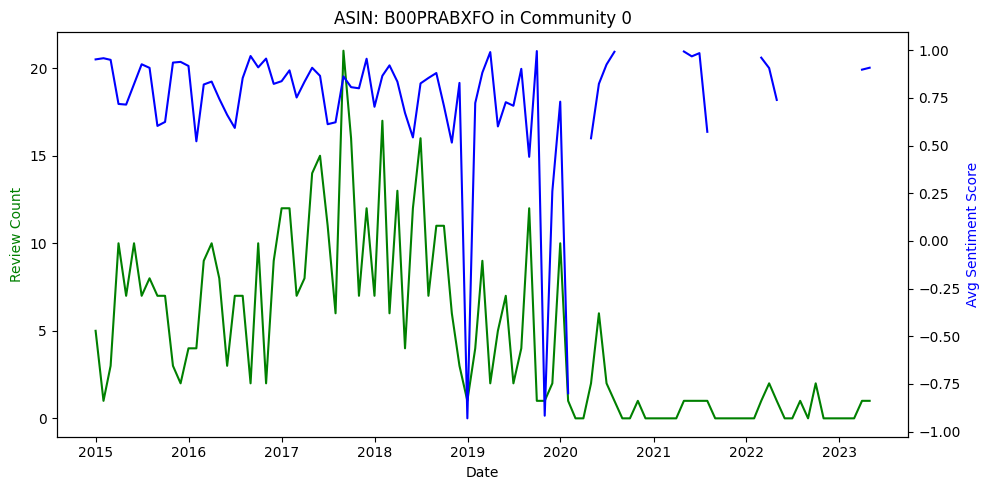

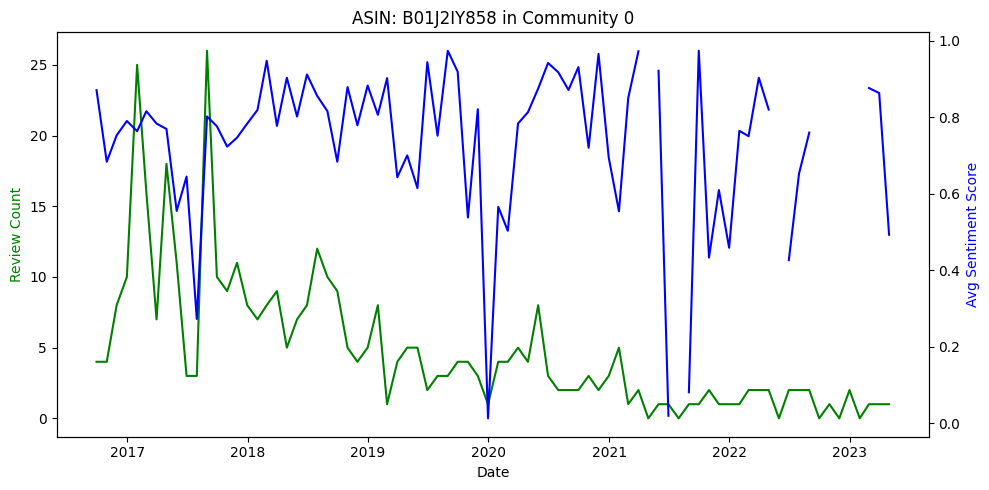

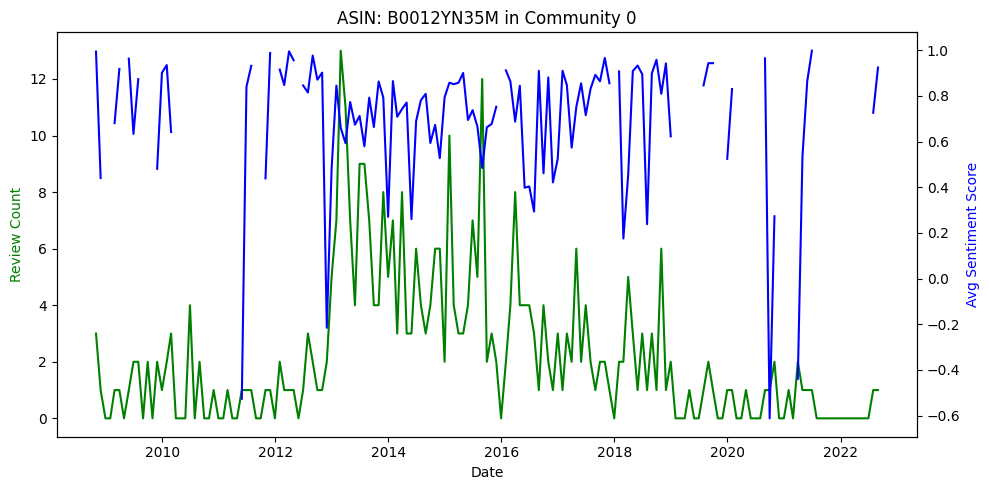

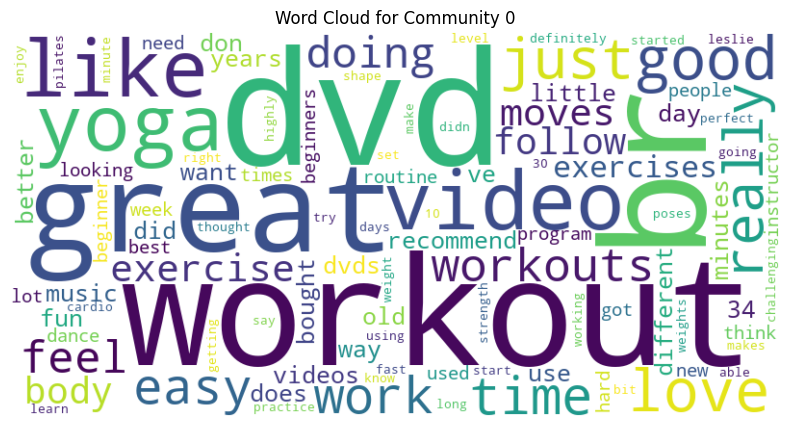

Community 1: 145666 reviews matched
  Top ASINs: ['B003ZSJ212', 'B005LAII80', 'B007ZQAKHU']


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/2636430870.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})


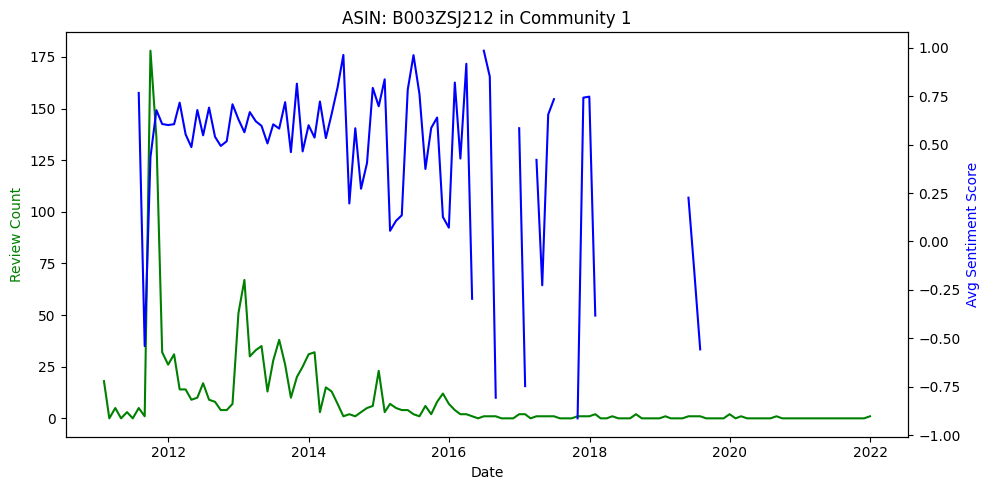

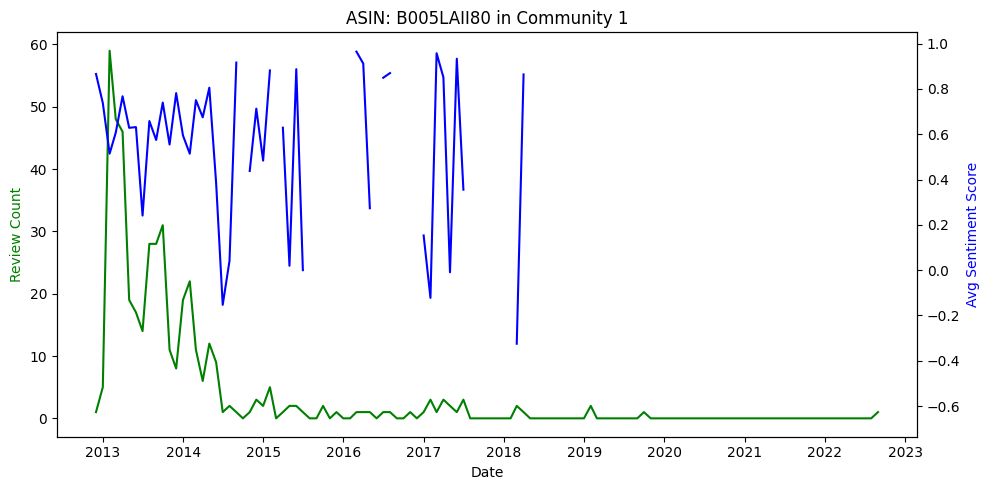

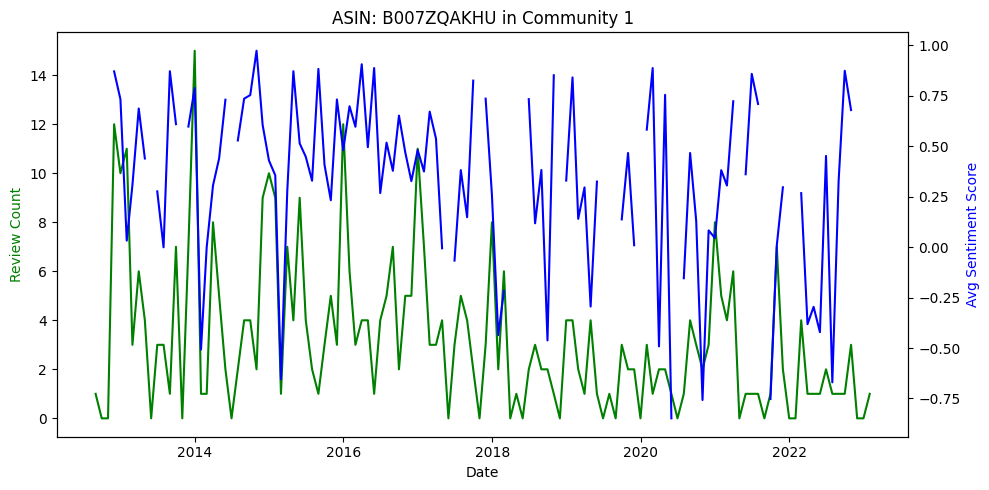

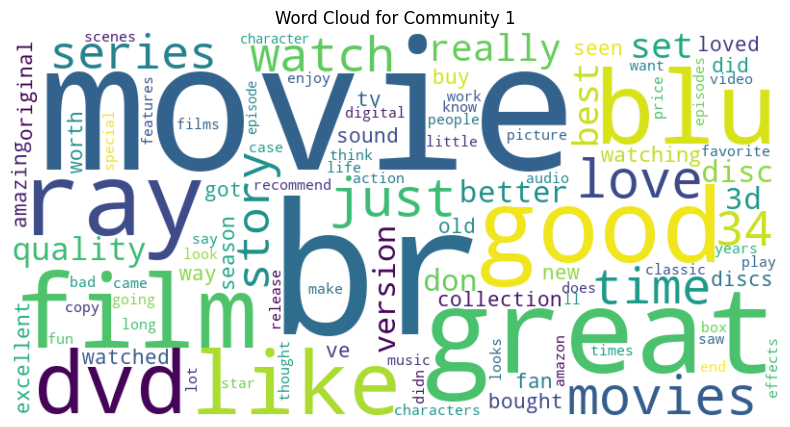

Community 2: 73359 reviews matched
  Top ASINs: ['B00AMR5LZA', 'B005LAIH2W', 'B0038M2AZA']


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/2636430870.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})


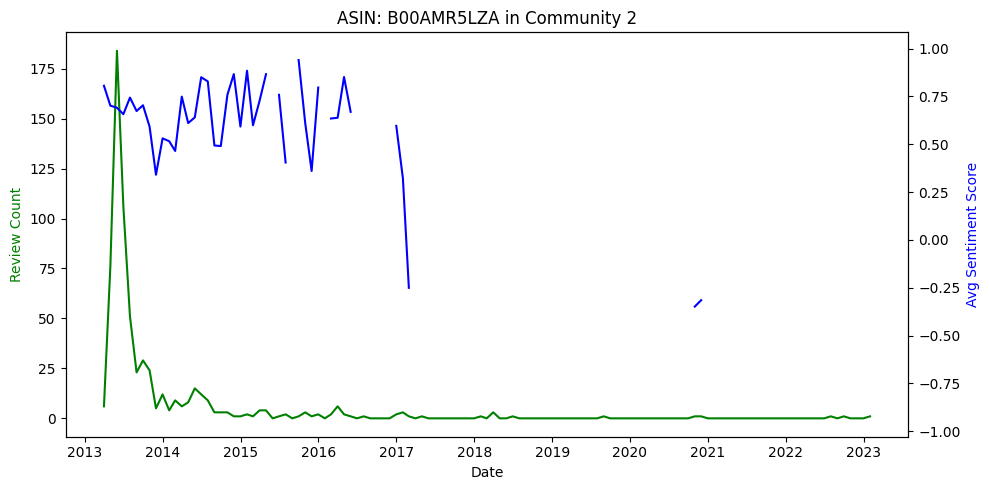

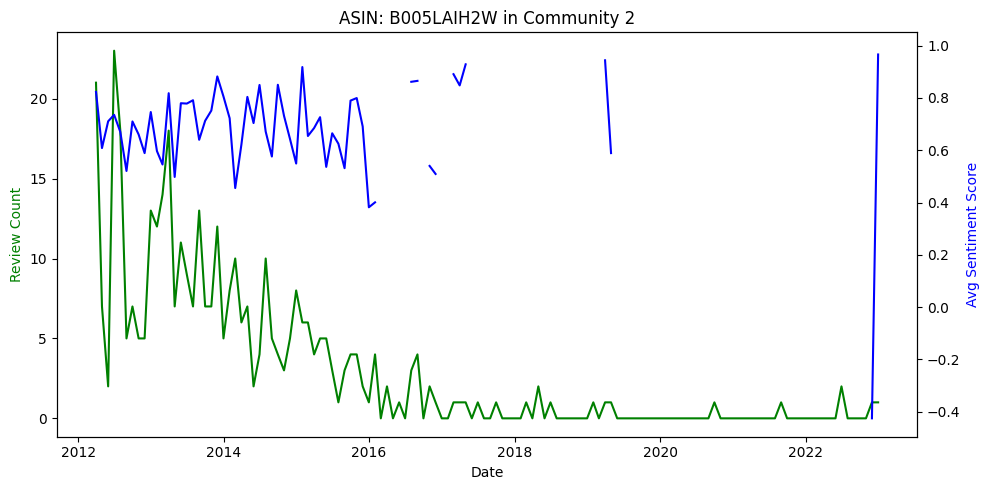

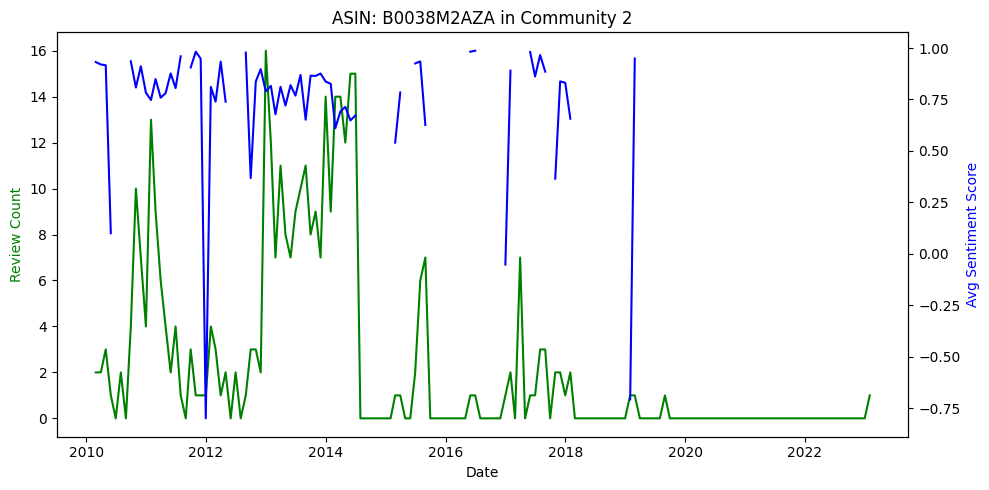

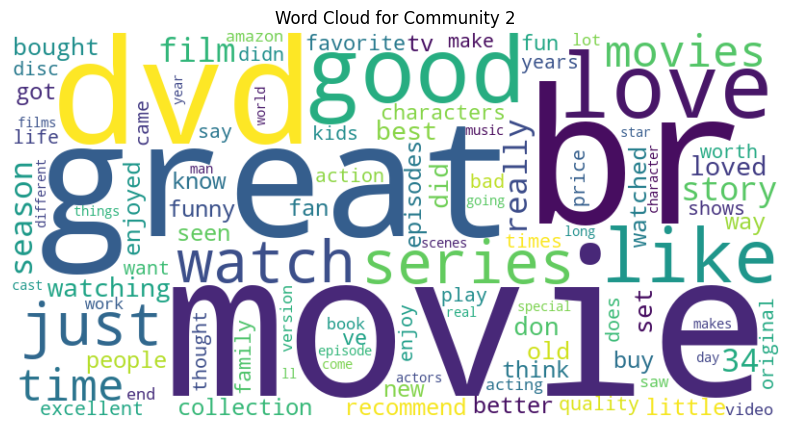

Community 3: 113511 reviews matched
  Top ASINs: ['B0094V8OXG', 'B0031RAOVY', 'B00LG7VWIA']


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/2636430870.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})


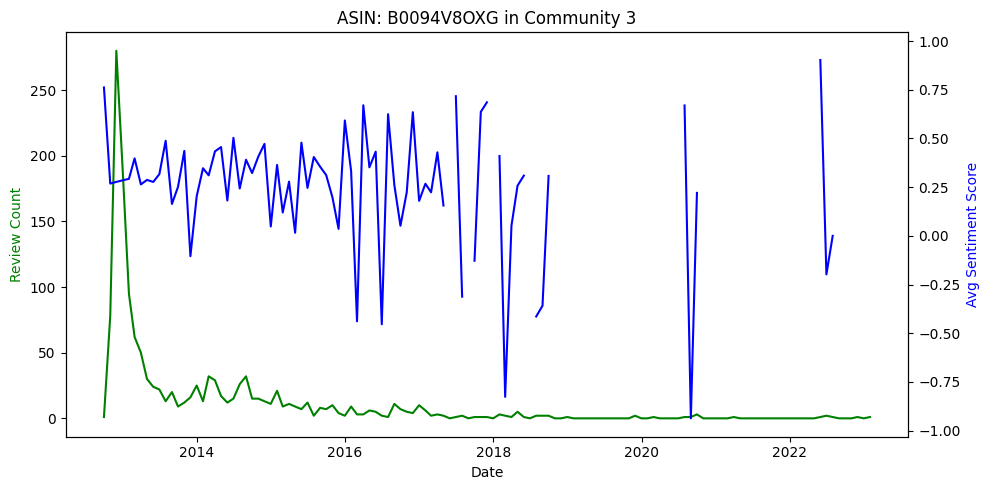

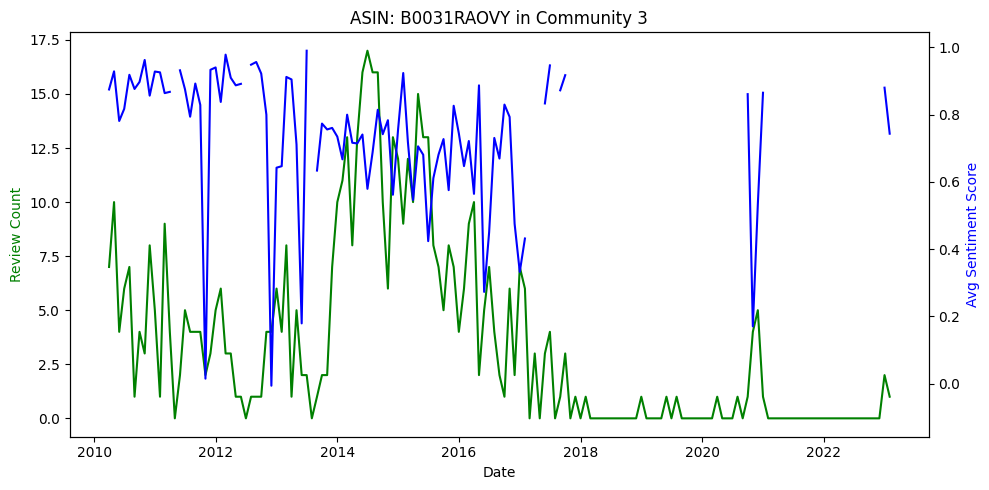

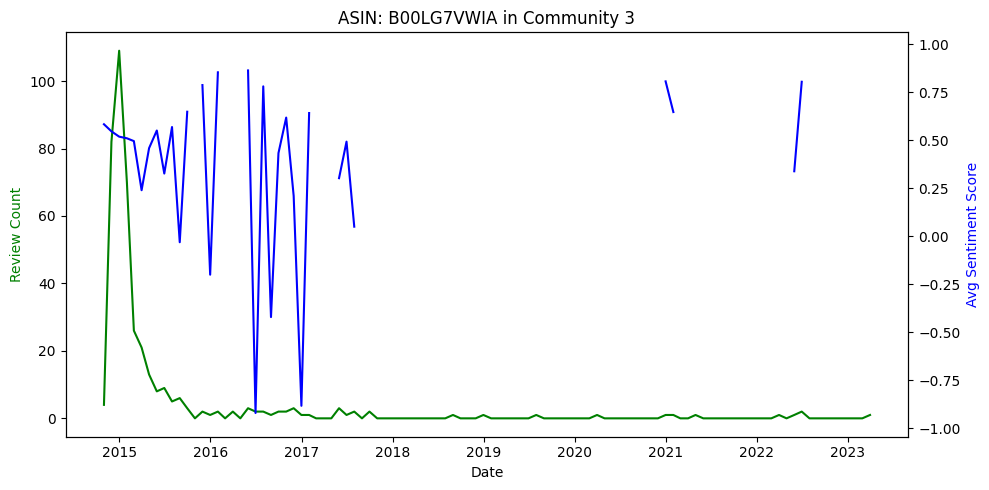

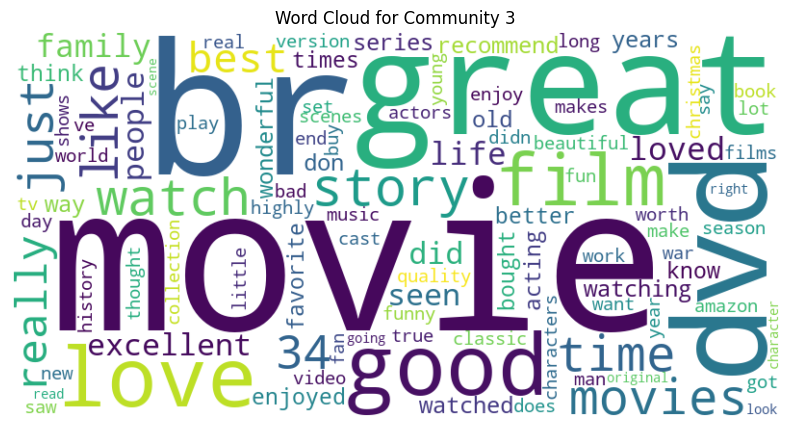

Community 4: 72304 reviews matched
  Top ASINs: ['B00F1BFRA6', 'B005OCFGTO', 'B005S9EJ14']


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/2636430870.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})


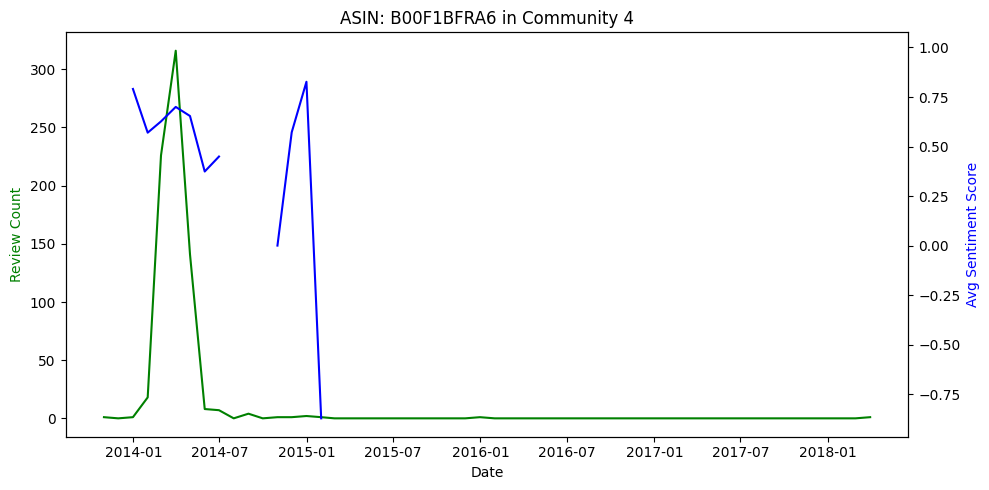

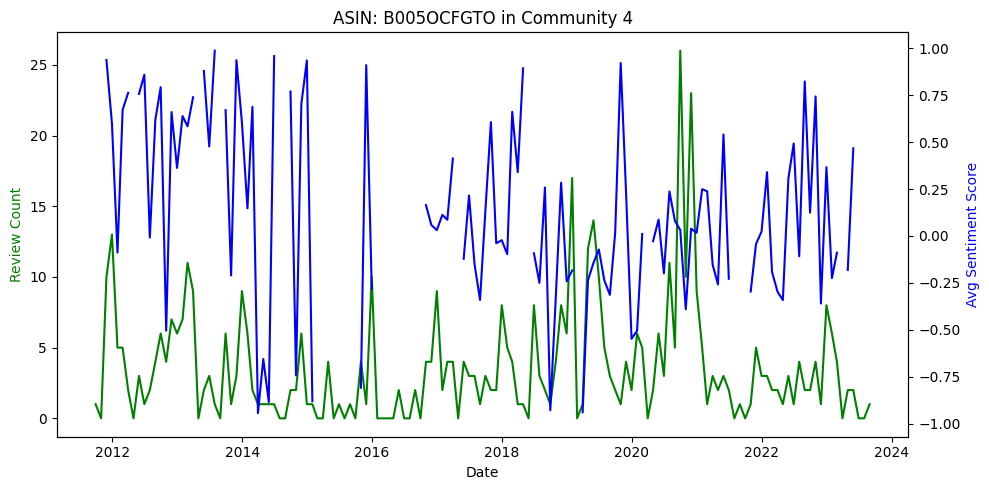

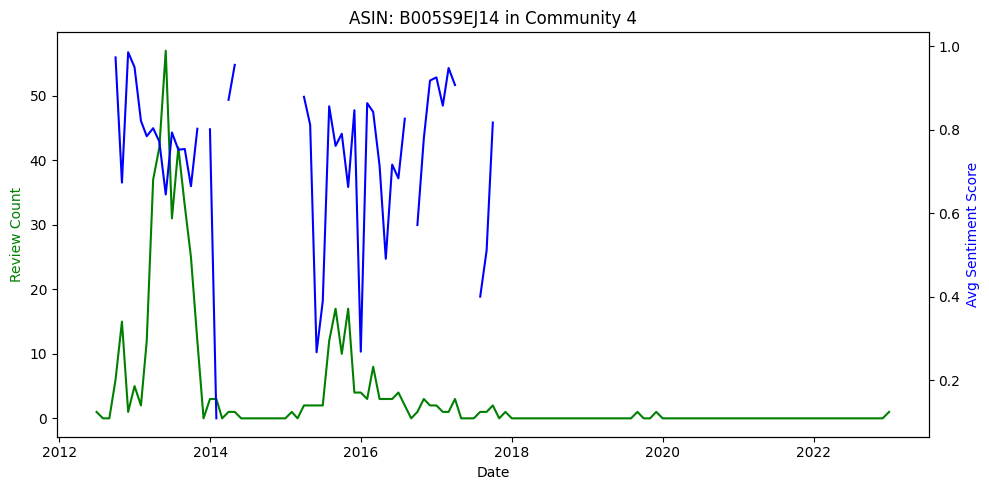

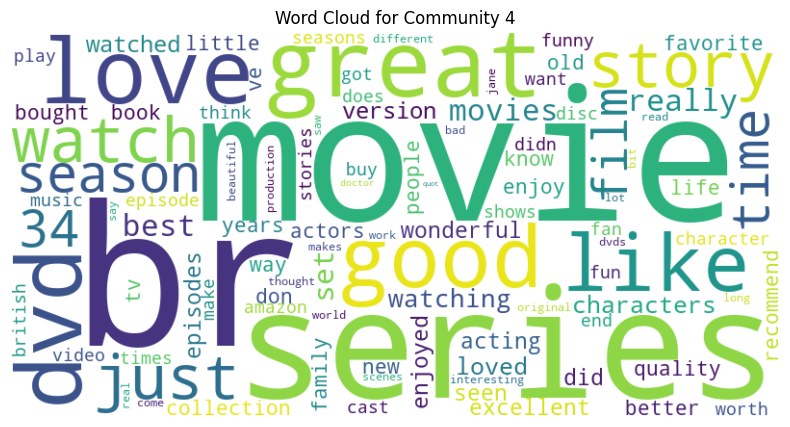

Community 5: 98185 reviews matched
  Top ASINs: ['B008RJ6TTC', 'B007PZ6SYK', 'B000H5U5EE']


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_50728/2636430870.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = sub_df.resample('M', on='timestamp').agg({'sentiment_score': 'mean', 'asin': 'count'})


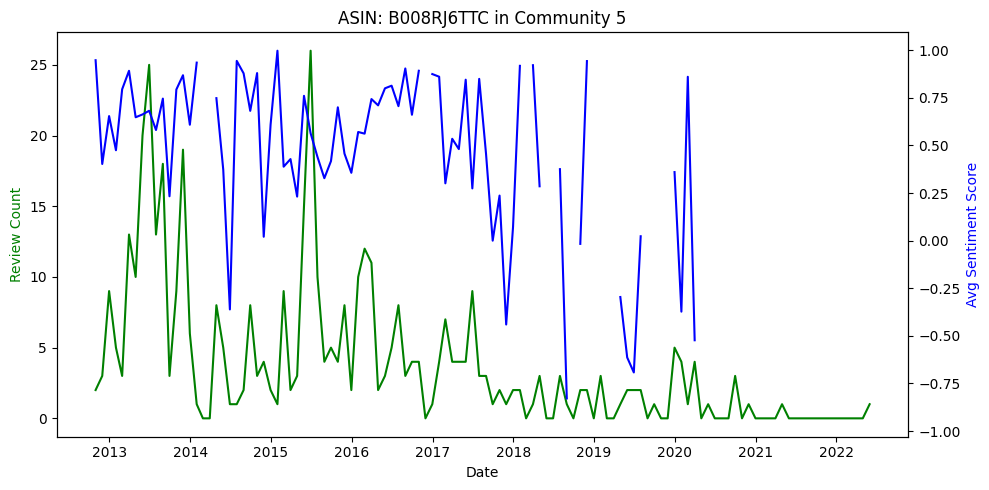

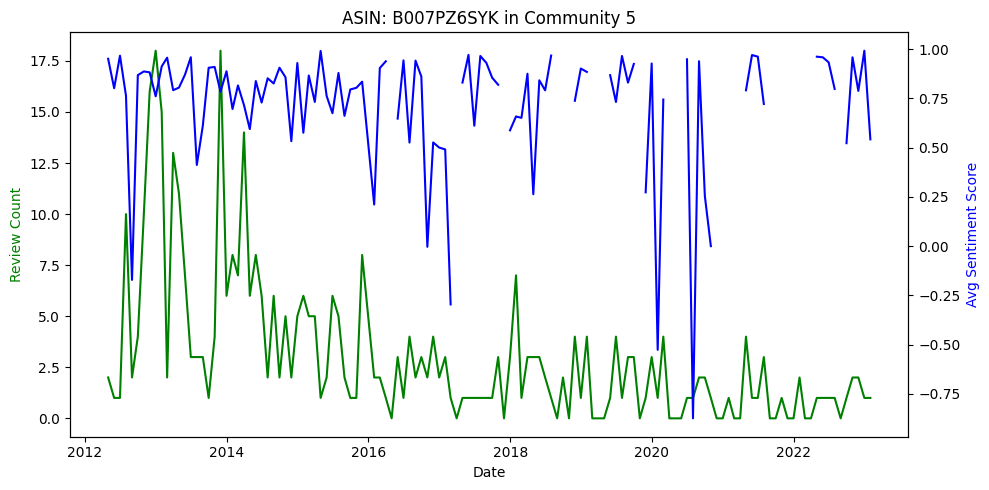

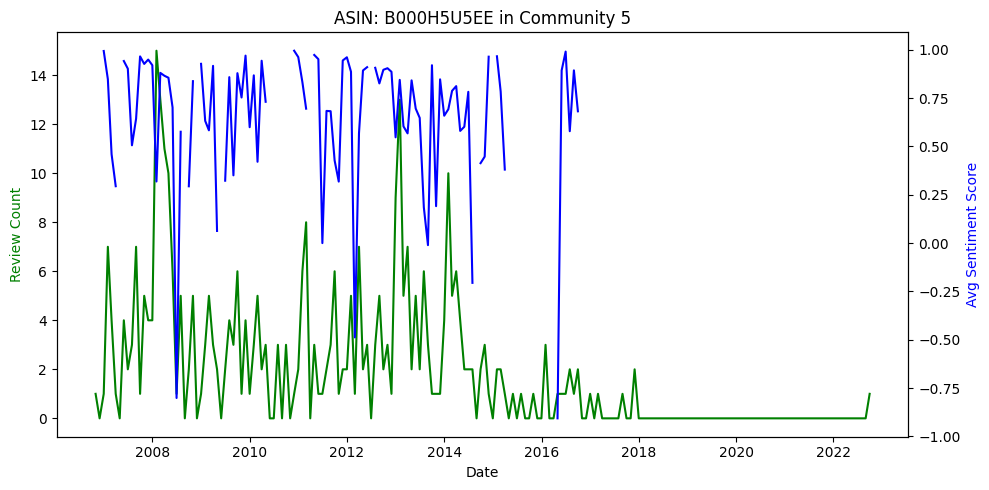

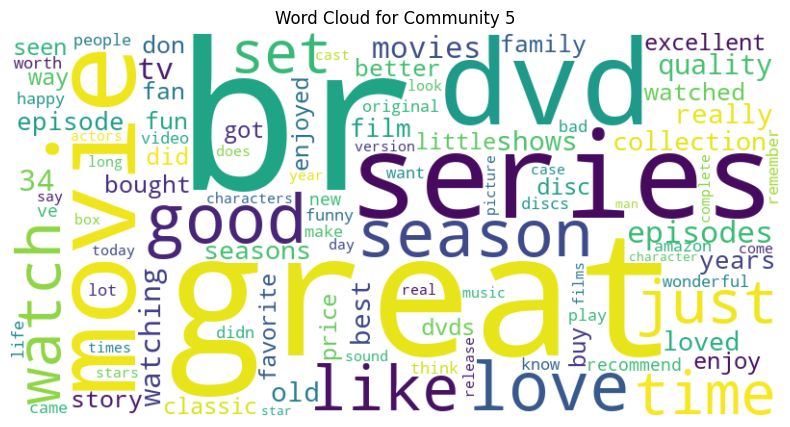

In [69]:
for comm_id, asin_list in communities.items():
    asin_list = list(map(str, asin_list))
    comm_df = df[df['asin'].isin(asin_list)]

    print(f"Community {comm_id}: {len(comm_df)} reviews matched")
    if comm_df.empty:
        continue

    top_asins = comm_df['asin'].value_counts().head(3).index.tolist()
    print(f"  Top ASINs: {top_asins}")

    plot_sentiment_trends(comm_df, top_asins, comm_id)
    generate_wordcloud(comm_df['text'].dropna().tolist(), comm_id)

In [48]:
# Print types and a few values from both sources
print("Sample ASINs in df:", df['asin'].dropna().astype(str).unique()[:5])
print("Sample nodes in Community 0:", list(communities.values())[0][:5])

# Check intersection directly
asin_set = set(df['asin'].dropna().astype(str).unique())
comm_set = set(map(str, list(communities.values())[0]))

overlap = asin_set.intersection(comm_set)
print("Overlap:", len(overlap))
print("Overlapping ASINs:", list(overlap)[:5])


Sample ASINs in df: []
Sample nodes in Community 0: ['B0002J58ME', 'B001F76OKC', 'B00147FVKW', 'B0042FDCMW', 'B00B5LIE4C']
Overlap: 0
Overlapping ASINs: []


### Some graph stats

In [65]:
print("\\n--- Graph Statistics ---")
print(f"Clustering Coefficient: {nx.average_clustering(Graph):.4f}")
print(f"Assortativity Coefficient: {nx.degree_assortativity_coefficient(Graph):.4f}")
if nx.is_connected(Graph):
    print(f"Average Shortest Path Length: {nx.average_shortest_path_length(Graph):.2f}")
    print(f"Diameter: {nx.diameter(Graph)}")
else:
    largest_cc = max(nx.connected_components(Graph), key=len)
    subgraph = Graph.subgraph(largest_cc)
    # print(f"(Subgraph) Avg Shortest Path: {nx.average_shortest_path_length(subgraph):.2f}")
    # print(f"(Subgraph) Diameter: {nx.diameter(subgraph)}")

\n--- Graph Statistics ---
Clustering Coefficient: 0.2646
Assortativity Coefficient: 0.4789
